In [1]:
%matplotlib widget
import torch
import matplotlib.pyplot as plt
import pandas as pd

from utils import config
from utils import utils


from utils.models import Regressor
from utils import mmfit_data as mmfit

KeyboardInterrupt: 

In [8]:
def acc_frame_time(real_acc):
    acc_frame_time = real_acc[:, :2].cpu()
    df = pd.DataFrame(acc_frame_time, columns=['frame', 'time'])
    df = df.drop_duplicates(subset=['frame'], keep='first').reset_index(drop=True)
    frame_time = df.to_numpy() # (N, 2)
    return frame_time

def frame_to_timestamp(frame, frame_time_df):
    filtered_df = frame_time_df.loc[frame_time_df['frame'] == frame, 'time']
    if not filtered_df.empty:
        return filtered_df.iloc[0]
    else:
        # Handle the case where the frame does not exist in frame_time_df
        # You can return None, or raise a more informative error
        return None  # Or raise an exception
        
    # return frame_time_df.loc[frame_time_df['frame'] == frame, 'time'].iloc[0]

def plot_real_pred_acc(real_acc_data, pred_acc, time, labels):
    """
    real_acc_data (3, N)
    pred_acc (3, N)
    """
    # plot ACCs #
    color_real = 'blue'
    color_pred = 'orange'

    fig, ax = plt.subplots(3, 1, figsize=(10, 6))
    fig.subplots_adjust(hspace=0.5)
    ax[0].plot(time, real_acc_data[0, :].cpu(), label='real', color=color_real)
    ax[0].plot(time, pred_acc[0, :].cpu(), label='predicted', color=color_pred, alpha=0.7)
    ax[0].set_title('x')
    ax[0].legend()

    ax[1].plot(time, real_acc_data[1, :].cpu(), label='real' , color=color_real)
    ax[1].plot(time, pred_acc[1, :].cpu(), label='predicted', color=color_pred, alpha=0.7)
    ax[1].set_title('y')
    ax[1].legend()

    ax[2].plot(time, real_acc_data[2, :].cpu(), label='real' , color=color_real)
    ax[2].plot(time, pred_acc[2, :].cpu(), label='predicted', color=color_pred, alpha=0.7)
    ax[2].set_title('z')
    ax[2].legend()

    # plot label
    labels = dataset.labels
    labels_df = pd.DataFrame(labels, columns=['start_frame', 'end_frame', 'rep', 'label'])
    frame_time = acc_frame_time(real_acc)
    frame_time_df = pd.DataFrame(frame_time, columns=['frame', 'time'])

    for i, label in labels_df.iterrows():
        start_time = frame_to_timestamp(frame=label['start_frame'], frame_time_df=frame_time_df)
        end_time = frame_to_timestamp(frame=label['end_frame'], frame_time_df=frame_time_df)
        for j in range(0, 3):
            ax[j].axvspan(start_time, end_time, color='gray', alpha=0.3)


    fig.suptitle('Real/Predicted ACC comparison')
    plt.show()


In [6]:
# >>> REGRESSOR <<< #
pose2imu_model = Regressor(
    in_ch=config.in_ch, num_joints=config.num_joints, window_length=config.sensor_window_length
).to(config.device)
# best_seed = config.best_pose2imu_seed # BEST Seed
# name = config.pose2imu_model_name + f"[{best_seed}](model).pth"
# name = '16.00_pose2imu[1](model)'
# name = '16.02_0_scenario2[s=2024][a=1][b=100](model)'
latest_model = utils.find_latest_model(name)
print(f"loading: {latest_model}")
pose2imu_model.load_state_dict(torch.load(latest_model, map_location=config.device))

loading: ../train_out/22.02/16.00_pose2imu[1](model).pth


<All keys matched successfully>

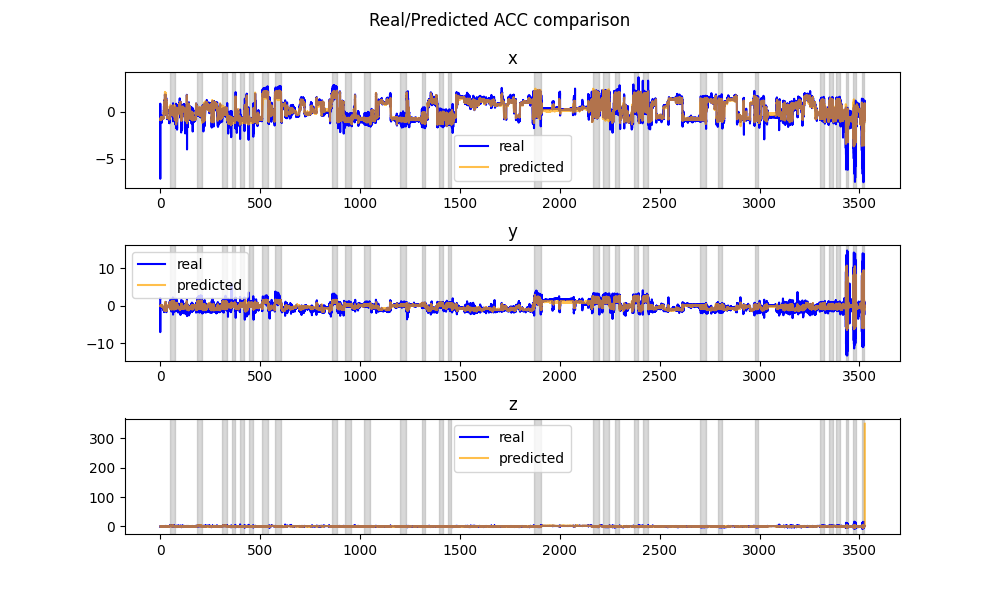

In [9]:
dataset = mmfit.test_datasets.datasets[0] # change to whatever dataset you want
real_acc = dataset.acc  # (N, 5)
time = real_acc[:, 1].cpu()
real_acc_data = real_acc[:, 2:].permute(1, 0)  # (3, N)
labels = dataset.labels

pred_acc = torch.empty_like(real_acc_data).to(config.device) # (3, N)
mmfit.unfold(model=pose2imu_model, dataset=dataset, pred_acc=pred_acc)

plot_real_pred_acc(real_acc_data=real_acc_data, pred_acc=pred_acc, time=time, labels=labels)